In [1]:
import numpy as np
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt
import time 

In [2]:
Coeff_Matrix_IP=sio.loadmat("Indian_pines_corrected.mat")['indian_pines_corrected']

In [3]:
Coeff_Matrix_IP.shape

(145, 145, 200)

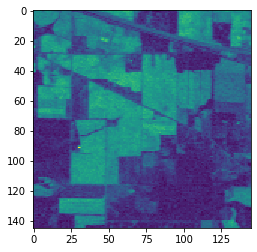

In [4]:
plt.imshow(Coeff_Matrix_IP[:,:,150])

In [5]:
width=145
height=145
dsize=(width,height) 

In [6]:
output_list=[]
for i in range(0,200):
    output_list.append(cv2.resize(Coeff_Matrix_IP[:,:,i], dsize,interpolation=cv2.INTER_NEAREST ))
output_array=np.asarray(output_list)
output_array.shape


(200, 145, 145)

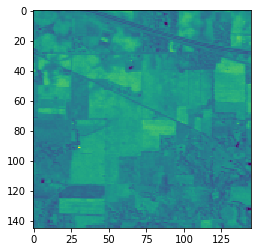

In [7]:
plt.imshow(output_array[100,:,:])

In [8]:
def featureNormalize(X):
    mu = np.mean(X,0)
    X_norm = X-mu
    sigma = np.std(X_norm,0)
    X_norm = X_norm/sigma
    return X_norm

In [9]:
def LDANorm(X,Y,num_PC):
  from sklearn.decomposition import LatentDirichletAllocation
  lda = LatentDirichletAllocation(n_components=num_PC)      
  y=Y.flatten
  XLDANorm = lda.fit(X,y).transform(X)
  return XLDANorm

In [10]:
def PCANorm(X,num_PC):
    mu = np.mean(X,0)
    X_norm = X-mu
    Sigma = np.cov(X_norm.T)
    [U, S, V] = np.linalg.svd(Sigma)   
    XPCANorm = np.dot(X_norm,U[:,0:num_PC])
    return XPCANorm

In [11]:
def MirrowCut(X,hw): 
    #X  size: row * column * num_feature

    [row,col,n_feature] = X.shape

    X_extension = np.zeros((3*row,3*col,n_feature))
    
    for i in range(0,n_feature):
        lr = np.fliplr(X[:,:,i])
        ud = np.flipud(X[:,:,i])
        lrud = np.fliplr(ud)
        
        l1 = np.concatenate((lrud,ud,lrud),axis=1)
        l2 = np.concatenate((lr,X[:,:,i],lr),axis=1)
        l3 = np.concatenate((lrud,ud,lrud),axis=1)
        
        X_extension[:,:,i] = np.concatenate((l1,l2,l3),axis=0)
    
    X_extension = X_extension[row-hw:2*row+hw,col-hw:2*col+hw,:]
    
    return X_extension

In [12]:
def DrawResult(labels):
    num_class = labels.max()+1
    row = 145
    col = 145
    palette = np.array([[255,0,0],
                            [0,255,0],
                            [0,0,255],
                            [255,255,0],
                            [0,255,255],
                            [255,0,255],
                            [176,48,96],
                            [46,139,87],
                            [160,32,240],
                            [255,127,80],
                            [127,255,212],
                            [218,112,214],
                            [160,82,45],
                            [127,255,0],
                            [216,191,216],
                            [238,0,0]])
    palette = palette*1.0/255
    X_result = np.zeros((labels.shape[0],3))
    for i in range(0,num_class):
        X_result[np.where(labels==i),0] = palette[i,0]
        X_result[np.where(labels==i),1] = palette[i,1]
        X_result[np.where(labels==i),2] = palette[i,2]
    
    X_result = np.reshape(X_result,(row,col,3))
    plt.axis ( "off" ) 
    plt.imshow(X_result)    
    return X_result

In [13]:
def CalAccuracy(predict,label):
    n = label.shape[0]
    OA = np.sum(predict==label)*1.0/n
    correct_sum = np.zeros((max(label)+1))
    reali = np.zeros((max(label)+1))
    predicti = np.zeros((max(label)+1))
    producerA = np.zeros((max(label)+1))
    
    for i in range(0,max(label)+1):
        correct_sum[i] = np.sum(label[np.where(predict==i)]==i)
        reali[i] = np.sum(label==i)
        predicti[i] = np.sum(predict==i)
        producerA[i] = correct_sum[i] / reali[i]
   
    Kappa = (n*np.sum(correct_sum) - np.sum(reali * predicti)) *1.0/ (n*n - np.sum(reali * predicti))
    return OA,Kappa,producerA

In [14]:
def HyperspectralSamples(dataID=2, timestep=4, w=24, num_PC=3, israndom=False, s1s2=2):   
    data = sio.loadmat('Indian_pines_gt.mat')
    X=sio.loadmat("Indian_pines_corrected.mat")['indian_pines_corrected']
    Y = data['indian_pines_gt']
    train_num_array = [30, 150, 150, 100, 150, 150, 20, 150, 15, 150, 150, 150, 150, 150, 50, 50]
    train_num_array = np.array(train_num_array).astype('int')
    [row,col,n_feature] = X.shape
    K = row*col
    X = X.reshape(row*col, n_feature)    
    Y = Y.reshape(row*col, 1)    
    n_class = Y.max()
    nb_features = int(n_feature/timestep)
    train_num_all = sum(train_num_array)    
    X_train = np.zeros((train_num_all,timestep,nb_features))
    X_test = np.zeros((sum(Y>0)[0]-train_num_all,timestep,nb_features));
    
   # X_PCA = featureNormalize(PCANorm(X,num_PC)) 

    X_PCA=featureNormalize(LDANorm(X,Y,num_PC))
    X = featureNormalize(X)
    hw = int(w/2)
    
    X_PCAMirrow = MirrowCut(X_PCA.reshape(row,col,num_PC),hw)
    XP = np.zeros((K,w,w,num_PC))
    for i in range(1,K+1):
        index_row = int(np.ceil(i*1.0/col))
        index_col = i - (index_row-1)*col + hw -1 
        index_row += hw -1
        patch = X_PCAMirrow[index_row-hw:index_row+hw,index_col-hw:index_col+hw,:]
        XP[i-1,:,:,:] = patch 
     
    if israndom==True:
        randomArray = list()
        for i in range(1,n_class+1):
            index = np.where(Y==i)[0]
            n_data = index.shape[0]
            randomArray.append(np.random.permutation(n_data))
    flag1=0
    flag2=0
    X_train = np.zeros((train_num_all,timestep,nb_features))
    XP_train = np.zeros((train_num_all,w,w,num_PC))  
    #XP_train = np.zeros((train_num_all,num_PC,w,w))  
    Y_train = np.zeros((train_num_all,1))
    X_test = np.zeros((sum(Y>0)[0]-train_num_all,timestep,nb_features))
    XP_test = np.zeros((sum(Y>0)[0]-train_num_all,w,w,num_PC))    
    #XP_test = np.zeros((sum(Y>0)[0]-train_num_all,num_PC,w,w))   
    Y_test = np.zeros((sum(Y>0)[0]-train_num_all,1))   
    for i in range(1,n_class+1):
        index = np.where(Y==i)[0]
        n_data = index.shape[0]
        train_num = train_num_array[i-1]
        randomX = randomArray[i-1]
        XP_train[flag1:flag1+train_num,:,:,:] = XP[index[randomX[0:train_num]],:,:,:]
        Y_train[flag1:flag1+train_num,0] = Y[index[randomX[0:train_num]],0]    
        XP_test[flag2:flag2+n_data-train_num,:,:,:] = XP[index[randomX[train_num:n_data]],:,:,:]
        Y_test[flag2:flag2+n_data-train_num,0] = Y[index[randomX[train_num:n_data]],0]       
        if s1s2==2:
            for j in range(0,timestep):
                X_train[flag1:flag1+train_num,j,:] = X[index[randomX[0:train_num]],j:j+(nb_features-1)*timestep+1:timestep]
                X_test[flag2:flag2+n_data-train_num,j,:] = X[index[randomX[train_num:n_data]],j:j+(nb_features-1)*timestep+1:timestep]  
        else:
            for j in range(0,timestep):
                X_train[flag1:flag1+train_num,j,:] = X[index[randomX[0:train_num]],j*nb_features:(j+1)*nb_features]
                X_test[flag2:flag2+n_data-train_num,j,:] = X[index[randomX[train_num:n_data]],j*nb_features:(j+1)*nb_features]     
        flag1 = flag1+train_num
        flag2 = flag2+n_data-train_num   
    X_reshape = np.zeros((X.shape[0],timestep,nb_features))
    if s1s2==2:  
        for j in range(0,timestep):
            X_reshape[:,j,:] = X[:,j:j+(nb_features-1)*timestep+1:timestep]
    else:
        for j in range(0,timestep):
            X_reshape[:,j,:] = X[:,j*nb_features:(j+1)*nb_features]
    X = X_reshape    
    return X.astype('float32'),X_train.astype('float32'),X_test.astype('float32'),XP.astype('float32'),XP_train.astype('float32'),XP_test.astype('float32'),Y.astype(int),Y_train.astype(int),Y_test.astype(int)

In [15]:
from keras.datasets import mnist
from keras.models import Model,Sequential,save_model,load_model
from keras.layers import Input, Dense, Activation,LSTM,Conv2D, MaxPooling2D,AveragePooling2D, Flatten,Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Concatenate
from keras.layers import Add
import tensorflow as tf 
import keras.backend.tensorflow_backend as KTF 

Using TensorFlow backend.
C:\Users\LOHIT\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\LOHIT\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\LOHIT\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\LOHIT\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [16]:
def SSUN(time_step,nb_features,num_PC,img_rows,img_cols):
    LSTMInput = Input(shape=(time_step,nb_features),name='LSTMInput')
    LSTMSpectral = LSTM(128,name='LSTMSpectral',consume_less='gpu',W_regularizer=l2(0.0001),U_regularizer=l2(0.0001))(LSTMInput)
    LSTMDense = Dense(128,activation='relu', name='LSTMDense')(LSTMSpectral)
    LSTMSOFTMAX = Dense(nb_classes,activation='softmax', name='LSTMSOFTMAX')(LSTMDense)    
    CNNInput = Input(shape=[img_rows,img_cols,num_PC],name='CNNInput')
    CONV1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV1')(CNNInput) 
    POOL1 = MaxPooling2D((2, 2), name='POOL1')(CONV1)   
    CONV2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV2')(POOL1)
    POOL2 = MaxPooling2D((2, 2), name='POOL2')(CONV2)
    CONV3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV3')(POOL2)
    POOL3 = MaxPooling2D((2, 2), name='POOL3')(CONV3)
    FLATTEN1 = Flatten(name='FLATTEN1')(POOL1)
    FLATTEN2 = Flatten(name='FLATTEN2')(POOL2)
    FLATTEN3 = Flatten(name='FLATTEN3')(POOL3)
    DENSE1 = Dense(128,activation='relu', name='DENSE1')(FLATTEN1)
    DENSE2 = Dense(128,activation='relu', name='DENSE2')(FLATTEN2)
    DENSE3 = Dense(128,activation='relu', name='DENSE3')(FLATTEN3)
    CNNDense = Add()([DENSE1, DENSE2, DENSE3])
    CNNSOFTMAX = Dense(nb_classes,activation='softmax', name='CNNSOFTMAX')(CNNDense)
    JOINT = Concatenate()([LSTMDense,CNNDense])
    JOINTDENSE = Dense(128,activation='relu', name='JOINTDENSE')(JOINT)
    JOINTSOFTMAX = Dense(nb_classes,activation='softmax',name='JOINTSOFTMAX')(JOINTDENSE)
    model = Model(input=[LSTMInput,CNNInput], output=[JOINTSOFTMAX,LSTMSOFTMAX,CNNSOFTMAX])    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=['accuracy'],loss_weights=[1, 1,1])
    return model

def LSTM_RS(time_step,nb_features):
    LSTMInput = Input(shape=(time_step,nb_features),name='LSTMInput')
    LSTMSpectral = LSTM(128,name='LSTMSpectral',consume_less='gpu',W_regularizer=l2(0.0001),U_regularizer=l2(0.0001))(LSTMInput)
    LSTMDense = Dense(128,activation='relu', name='LSTMDense')(LSTMSpectral)
    LSTMSOFTMAX = Dense(nb_classes,activation='softmax', name='LSTMSOFTMAX')(LSTMDense)
    model = Model(input=[LSTMInput], output=[LSTMSOFTMAX])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def MSCNN_RS(num_PC,img_rows,img_cols):
    CNNInput = Input(shape=[img_rows,img_cols,num_PC],name='CNNInput')
    CONV1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV1')(CNNInput) 
    POOL1 = MaxPooling2D((2, 2), name='POOL1')(CONV1)   
    CONV2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV2')(POOL1)
    POOL2 = MaxPooling2D((2, 2), name='POOL2')(CONV2)
    CONV3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='CONV3')(POOL2)
    POOL3 = MaxPooling2D((2, 2), name='POOL3')(CONV3)
    FLATTEN1 = Flatten(name='FLATTEN1')(POOL1)
    FLATTEN2 = Flatten(name='FLATTEN2')(POOL2)
    FLATTEN3 = Flatten(name='FLATTEN3')(POOL3)
    DENSE1 = Dense(128,activation='relu', name='DENSE1')(FLATTEN1)
    DENSE2 = Dense(128,activation='relu', name='DENSE2')(FLATTEN2)
    DENSE3 = Dense(128,activation='relu', name='DENSE3')(FLATTEN3)
    CNNDense = Add()([DENSE1, DENSE2, DENSE3])
    CNNSOFTMAX = Dense(nb_classes,activation='softmax', name='CNNSOFTMAX')(CNNDense)
    model = Model(input=[CNNInput], output=[CNNSOFTMAX])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, name="LSTMSpectral", kernel_regularizer=<keras.reg..., recurrent_regularizer=<keras.reg..., implementation=2)`




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/500
1765/1765 [==============================] - 1s 441us/step - loss: 2.8129 - acc: 0.0912
Epoch 2/500
1765/1765 [==============================] - 0s 44us/step - loss: 2.6696 - acc: 0.3156
Epoch 3/500
1765/1765 [==============================] - 0s 37us/step - loss: 2.5422 - acc: 0.3581
Epoch 4/500
1765/1765 [==============================] - 0s 34us/step - loss: 2.4207 - acc: 0.3558
Epoch 5/500
1765/1765 [==============================] - 0s 34us/step - loss: 2.3020 - acc: 0.3592
Epoch 6/500
1765/1765 [==============================] - 0s 33us/step - loss: 2.1882 - acc: 0.3768
Epoch 7/500
1765/1765 [==============================] - 0s 34us/step - loss: 2.0789 - acc: 0.4062
Epoch 8/500
1765/1765 [==============================] - 0s 35us/step - loss: 1.9780 - acc: 0.4261
Epoch 9/500
1765/1765 [==============================] - 0s 36us/step - loss: 1.8880 - acc: 0.4312
Epoch 10/500
1765/1765 [==============================] - 0s 37us/step - loss: 1.8092 - acc: 0.4504
Epoch 1

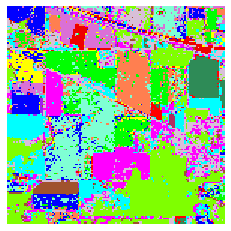

In [17]:
w=28
num_PC=4
israndom=True
randtime = 1
OASpectral_Pavia = np.zeros((16+2,randtime))
s1s2=1
time_step=1
for r in range(0,randtime):
    dataID=2
    data = HyperspectralSamples(dataID=dataID, timestep=time_step, w=w, num_PC=num_PC, israndom=israndom, s1s2=s1s2)
    X = data[0]
    X_train = data[1]
    X_test = data[2]
    XP = data[3]
    XP_train = data[4]
    XP_test = data[5]
    Y = data[6]-1
    Y_train = data[7]-1
    Y_test = data[8]-1
    batch_size = 128
    nb_classes = Y_train.max()+1
    nb_epoch = 500
    nb_features = X.shape[-1]
    img_rows, img_cols = XP.shape[1],XP.shape[1]
    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(Y_train, nb_classes)
    y_test = np_utils.to_categorical(Y_test, nb_classes)
    model = LSTM_RS(time_step=time_step,nb_features=nb_features)
    histloss=model.fit([X_train], [y_train], nb_epoch=nb_epoch, batch_size=batch_size, verbose=1, shuffle=True)
    losses = histloss.history
    PredictLabel = model.predict([X_test],verbose=1).argmax(axis=-1)
    OA,Kappa,ProducerA = CalAccuracy(PredictLabel,Y_test[:,0])    
    OASpectral_Pavia[0:16,r] = ProducerA
    OASpectral_Pavia[-2,r] = OA
    OASpectral_Pavia[-1,r] = Kappa
    print('rand',r+1,'LSTM Indian Pines test accuracy:', OA*100)
    Map = model.predict([X],verbose=1)
    Spectral = Map.argmax(axis=-1)
    X_result = DrawResult(Spectral)
    plt.imsave('LSTM_Indian Pines_r'+repr(r+1)+'OA_'+repr(int(OA*10000))+'.png',X_result)

In [18]:
Accuracy_spectral=OA*100
Accuracy_spectral

81.71852899575673

C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/500
1765/1765 [==============================] - 2s 1ms/step - loss: 2.3933 - acc: 0.2589
Epoch 2/500
1765/1765 [==============================] - 1s 673us/step - loss: 1.5400 - acc: 0.5626
Epoch 3/500
1765/1765 [==============================] - 1s 649us/step - loss: 1.1149 - acc: 0.6975
Epoch 4/500
1765/1765 [==============================] - 1s 664us/step - loss: 0.8503 - acc: 0.7745
Epoch 5/500
1765/1765 [==============================] - 1s 760us/step - loss: 0.6725 - acc: 0.8295
Epoch 6/500
1765/1765 [==============================] - 1s 778us/step - loss: 0.5529 - acc: 0.8663
Epoch 7/500
1765/1765 [==============================] - 1s 622us/step - loss: 0.4624 - acc: 0.8907
Epoch 8/500
1765/1765 [==============================] - 2s 953us/step - loss: 0.3930 - acc: 0.9133
Epoch 9/500
1765/1765 [==============================] - 2s 938us/step - loss: 0.3320 - acc: 0.9348
Epoch 10/500
1765/1765 [==============================] - 1s 609us/step - loss: 0.2819 - acc: 0.9552
E

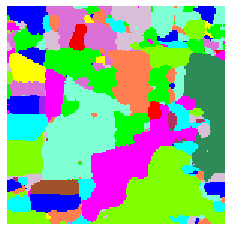

In [19]:
w=28
num_PC=4
israndom=True
randtime = 1
OASpatial_Pavia = np.zeros((16+2,randtime))
s1s2=1
time_step=1
for r in range(0,randtime):
    dataID=2
    data = HyperspectralSamples(dataID=dataID, timestep=time_step, w=w, num_PC=num_PC, israndom=israndom, s1s2=s1s2)
    X = data[0]
    X_train = data[1]
    X_test = data[2]
    XP = data[3]
    XP_train = data[4]
    XP_test = data[5]
    Y = data[6]-1
    Y_train = data[7]-1
    Y_test = data[8]-1
    batch_size = 128
    nb_classes = Y_train.max()+1
    nb_epoch = 500
    nb_features = X.shape[-1]
    img_rows, img_cols = XP.shape[1],XP.shape[1]
    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(Y_train, nb_classes)
    y_test = np_utils.to_categorical(Y_test, nb_classes)
    model = MSCNN_RS(num_PC,img_rows,img_cols)
    histloss=model.fit([XP_train], [y_train], nb_epoch=nb_epoch, batch_size=batch_size, verbose=1, shuffle=True)
    losses = histloss.history
    PredictLabel = model.predict([XP_test],verbose=1).argmax(axis=-1)
    OA,Kappa,ProducerA = CalAccuracy(PredictLabel,Y_test[:,0])    
    OASpatial_Pavia[0:16,r] = ProducerA
    OASpatial_Pavia[-2,r] = OA
    OASpatial_Pavia[-1,r] = Kappa
    print('rand',r+1,'MSCNN indian pines test accuracy:', OA*100)
    Map = model.predict([XP],verbose=1)
    Spatial = Map.argmax(axis=-1)
    X_result = DrawResult(Spatial)
    plt.imsave('MSCNN_indianpines_r'+repr(r+1)+'OA_'+repr(int(OA*10000))+'.png',X_result)

In [20]:
Accuracy_spatial=OA*100
Accuracy_spatial

96.82932578972184

C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, name="LSTMSpectral", kernel_regularizer=<keras.reg..., recurrent_regularizer=<keras.reg..., implementation=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
C:\Users\LOHIT\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/500
1765/1765 [==============================] - 3s 2ms/step - loss: 7.5521 - JOINTSOFTMAX_loss: 2.5351 - LSTMSOFTMAX_loss: 2.7459 - CNNSOFTMAX_loss: 2.2467 - JOINTSOFTMAX_acc: 0.2136 - LSTMSOFTMAX_acc: 0.0929 - CNNSOFTMAX_acc: 0.2771
Epoch 2/500
1765/1765 [==============================] - 1s 677us/step - loss: 6.1921 - JOINTSOFTMAX_loss: 2.0067 - LSTMSOFTMAX_loss: 2.6030 - CNNSOFTMAX_loss: 1.5579 - JOINTSOFTMAX_acc: 0.4414 - LSTMSOFTMAX_acc: 0.2068 - CNNSOFTMAX_acc: 0.5501
Epoch 3/500
1765/1765 [==============================] - 2s 930us/step - loss: 5.2682 - JOINTSOFTMAX_loss: 1.6050 - LSTMSOFTMAX_loss: 2.4763 - CNNSOFTMAX_loss: 1.1625 - JOINTSOFTMAX_acc: 0.5864 - LSTMSOFTMAX_acc: 0.3490 - CNNSOFTMAX_acc: 0.6657
Epoch 4/500
1765/1765 [==============================] - 1s 654us/step - loss: 4.5849 - JOINTSOFTMAX_loss: 1.2942 - LSTMSOFTMAX_loss: 2.3580 - CNNSOFTMAX_loss: 0.9083 - JOINTSOFTMAX_acc: 0.6408 - LSTMSOFTMAX_acc: 0.3887 - CNNSOFTMAX_acc: 0.7524
Epoch 5/500
1765/1765 

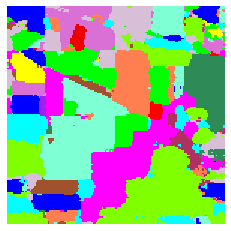

In [21]:
time_step=3
w=28
num_PC=4
israndom=True
s1s2=2
randtime = 1
OAJoint_Pavia = np.zeros((16+2,randtime))
for r in range(0,randtime):
    dataID=2
    data = HyperspectralSamples(dataID=dataID, timestep=time_step, w=w, num_PC=num_PC, israndom=israndom, s1s2=s1s2)
    X = data[0]
    X_train = data[1]
    X_test = data[2]
    XP = data[3]
    XP_train = data[4]
    XP_test = data[5]
    Y = data[6]-1
    Y_train = data[7]-1
    Y_test = data[8]-1
    batch_size = 128
    nb_classes = Y_train.max()+1
    nb_epoch = 500
    nb_features = X.shape[-1]
    img_rows, img_cols = XP.shape[1],XP.shape[1]
    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(Y_train, nb_classes)
    y_test = np_utils.to_categorical(Y_test, nb_classes)
    model = SSUN(time_step=time_step,nb_features=nb_features,num_PC=num_PC,img_rows=img_rows,img_cols=img_cols)
    histloss=model.fit([X_train,XP_train], [y_train,y_train,y_train], nb_epoch=nb_epoch, batch_size=batch_size, verbose=1, shuffle=True)
    losses = histloss.history
    PredictLabel = model.predict([X_test,XP_test],verbose=1)[0].argmax(axis=-1)
    OA,Kappa,ProducerA = CalAccuracy(PredictLabel,Y_test[:,0])    
    OAJoint_Pavia[0:16,r] = ProducerA
    OAJoint_Pavia[-2,r] = OA
    OAJoint_Pavia[-1,r] = Kappa
    print('rand',r+1,'SSUN indian pines test accuracy:', OA*100)
    Map = model.predict([X,XP],verbose=1)
    Joint = Map[0].argmax(axis=-1)
    X_result = DrawResult(Joint)
    plt.imsave('SSUN_indianpines_r'+repr(r+1)+'OA_'+repr(int(OA*10000))+'.png',X_result)
save_fn = 'OAAll.mat'
sio.savemat(save_fn, {'OASpectral_Pavia': OASpectral_Pavia,'OASpatial_Pavia': OASpatial_Pavia,'OAJoint_Pavia': OAJoint_Pavia})

In [22]:
Accuracy_final= OA*100
Accuracy_final

98.13767090994814

['Background-unclassified',
 'Corn-notill ',
 'Alfalfa ',
 'Corn-mintill',
 'Corn',
 'Grass-pasture',
 'Grass-trees',
 'Grass-pasture-mowed',
 'Hay-windrowed',
 'Oats',
 'Soybean-notill',
 'Soybean-mintill',
 'Soybean-clean',
 'Wheat',
 'Woods',
 'Buildings-Grass-Trees-Drives',
 'Stone-Steel-Towers']

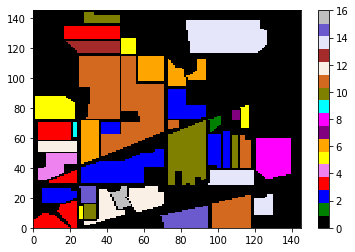

In [23]:
hsi_gt=sio.loadmat("Indian_pines_gt.mat")['indian_pines_gt']
from matplotlib.colors import ListedColormap
#discrete color scheme
cMap = ListedColormap(['black', 'green', 'blue','red','violet','yellow','orange','purple','magenta','cyan','olive','chocolate','linen','brown','lavender','slateblue','silver'])
fig, ax = plt.subplots()
heatmap = ax.pcolor(hsi_gt, cmap=cMap)
cbar = plt.colorbar(heatmap)
labels=['Background-unclassified','Corn-notill ','Alfalfa ','Corn-mintill','Corn','Grass-pasture','Grass-trees','Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-Grass-Trees-Drives','Stone-Steel-Towers',]
labels